In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets
import pickle
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import pairwise_distances
import pandas as pd
import seaborn as sns
from sklearn.covariance import MinCovDet
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.svm import OneClassSVM
from sklearn.metrics import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression
import math
sys.path.append('../..')
from lib.data_encoding import german_credit_encoding

In [2]:
class DetectorEnsemble:
    def __init__(self):
        self.detectors = []
        
        self.detectors.append(('iforest1', IsolationForest(random_state = 0, max_samples = 128, n_estimators = 100)))
        self.detectors.append(('iforest2', IsolationForest(random_state = 0, max_samples = 128, n_estimators = 200)))
        self.detectors.append(('iforest3', IsolationForest(random_state = 0, max_samples = 256, n_estimators = 100)))
        self.detectors.append(('iforest4', IsolationForest(random_state = 0, max_samples = 256, n_estimators = 200)))
        self.detectors.append(('iforest5', IsolationForest(random_state = 0, max_samples = 512, n_estimators = 100)))
        self.detectors.append(('iforest6', IsolationForest(random_state = 0, max_samples = 512, n_estimators = 200)))
        
        #self.detectors.append(('knn', NearestNeighbors(algorithm='ball_tree')))
        #self.detectors.append(('lof', LocalOutlierFactor(metric="precomputed")))
        #self.detectors.append(('robustcov', MinCovDet()))
        #self.detectors.append(('iforest', IsolationForest()))
        #self.detectors.append(('ocsvm', OneClassSVM()))
        #self.detectors.append(('dbscan',  DBSCAN()))
    
    def fit_detector(self, X, y):
        self.clf = LinearRegression(fit_intercept=True, normalize=False, copy_X=True).fit(X, y)

    def fit(self, mat):
        dist = pairwise_distances(X = mat, metric='euclidean')
        self.scores = []
        for (name, detector) in self.detectors:
            if name[:3] == 'lof':
                detector.fit_predict(dist)
                self.scores.append(-detector.negative_outlier_factor_)
            elif name == 'robustcov':
                detector.fit(mat)
                self.scores.append(detector.mahalanobis(mat))
            elif name == 'knn':
                detector.fit(mat)
                self.scores.append(-detector.kneighbors(mat)[0][:, -1])
            elif name == 'dbscan':
                detector.fit(mat)
                score = np.array([1 if x == -1 else 0 for x in detector.labels_])
                self.scores.append(score)
            else:
                detector.fit_predict(mat)
                self.scores.append(-detector.score_samples(mat))
            print(name, min(self.scores[-1]), max(self.scores[-1]), self.scores[-1].shape)
        tmp = []
        for score in self.scores:
            min_s = np.min(score)
            max_s = np.max(score)
            range_s = max(1, max_s - min_s)
            score = (score - min_s) / range_s
            tmp.append(score)
        self.n = mat.shape[0]
        self.scores = np.array(tmp)
        self.ground_truth = {}
        self.adjust_sample_weight = self.n // 100
        self.weights = np.ones(len(self.detectors))
        weights = self.weights / np.sum(self.weights)

        self.scores = self.scores.transpose()
        y = (self.scores * weights).sum(axis = 1)
        print('before fit', self.scores.shape, y.shape)
        self.fit_detector(self.scores, y)
        print('after fit')
    
    def weighted_score(self):
        y = self.clf.predict(self.scores)
        for i in self.ground_truth:
            y[i] = self.ground_truth[i]
        return y

    def adjust_weight(self, idx, score):
        self.ground_truth[idx] = score
        sample_weight = np.ones(self.n)
        for i in self.ground_truth:
            sample_weight[i] = self.adjust_sample_weight
        y = self.weighted_score()
        self.fit_detector(self.scores, y)


In [3]:
from model.german_rf import get_model
import sys
sys.path.append('../..')
from lib.tree_extractor import path_extractor
clf, (X_train, y_train, X_test, y_test, data_table), dataset, model, parameters = get_model()
paths = path_extractor(clf, 'random forest', (X_train, y_train))

target = 'credit_risk'
X = data_table.drop(target, axis=1).values
y = data_table[target].values
from lib.tree_extractor import assign_samples
assign_samples(paths, (X, y))

features = data_table.columns[1:]
new_feature = {}
feature_pos = {}
for index, feature in enumerate(features):
    if ' - ' in feature:
        name, p = feature.split(' - ')
        p = int(p)
        if name not in new_feature:
            new_feature[name] = []
        while p >= len(new_feature[name]):
            new_feature[name].append(-1)
        new_feature[name][p] = index
    else:
        new_feature[feature] = [index]

feature_range = {}
for key in new_feature:
    if key in data_table.columns:
        feature_range[key] = [data_table[key].min(), data_table[key].max() + 1]
    else:
        feature_range[key] = [0, len(new_feature[key])]
    for i, j in enumerate(new_feature[key]):
        feature_pos[j] = (key, i)


Test
Accuracy Score is 0.828
Precision Score is 0.8663101604278075
F1 Score is 0.88283378746594
Train
Accuracy Score is 0.8932692307692308


In [4]:
mat = np.array([p['sample'] for p in paths]).astype('float')
#for i, path in enumerate(paths):
#    mat[i] *= (path['output'] + 1)

ensemble = DetectorEnsemble()
ensemble.fit(mat)
selected_path_idxes = ensemble.weighted_score().argsort()[::-1]


iforest1 0.296211221206153 0.6107567870416208 (10058,)
iforest2 0.29606523946157165 0.605069082830885 (10058,)
iforest3 0.29737299967201747 0.6039397833574693 (10058,)
iforest4 0.29730844846205895 0.6088123210457891 (10058,)
iforest5 0.29860493551708156 0.6030050868814263 (10058,)
iforest6 0.2986118646558057 0.6011184614572143 (10058,)
before fit (10058, 6) (10058,)
after fit


/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


In [49]:
(mat == -0.5).sum()

36904

In [50]:
output_labels = ['reject', 'accept']
current_encoding = german_credit_encoding

def interpret_path(path):
    conds = {}
    for k in path['range']:
        name = feature_pos[k][0]
        val = path['range'][k]
        if name in current_encoding:
            if name not in conds:
                conds[name] = [1] * len(current_encoding[name])
            if name in data_table.columns:
                for i in range(feature_range[name][0], feature_range[name][1]):
                    if i < val[0] or i > val[1]:
                        conds[name][i - feature_range[name][0]] = 0
            else:
                if val[0] > 0:
                    conds[name] = [0] * len(current_encoding[name])
                    conds[name][feature_pos[k][1]] = 1
                else:
                    conds[name][feature_pos[k][1]] = 0
        else:
            cond = [max(feature_range[name][0], val[0]), min(feature_range[name][1], val[1])]
            conds[name] = cond

    output_conds = []
    for name in conds:
        val = conds[name]
        op = 'is'
        value = ''
        if name in current_encoding:
            is_negation = np.sum(val) * 2 >= len(val) and len(val) > 2
            if is_negation:
                op = 'is not'
                for i, d in enumerate(val):
                    if d == 0:
                        value = value + ' and ' + current_encoding[name][i]
                value = value[5:]
            else:
                for i, d in enumerate(val):
                    if d == 1:
                        value = value + ' or ' + current_encoding[name][i]
                value = value[4:]
        else:
            if val[0] == feature_range[name][0]:
                op = '<='
                value = int(val[1])
            elif val[1] == feature_range[name][1]:
                op = '>='
                value = int(val[0])
            else:
                op = 'in'
                value = '%d to %d' % (int(val[0]), int(val[1]))
        output_conds.append((name, op, value))
    output_label = output_labels[path['output']]
    # print(output_labels, path['output'])
    # print(conds)
    return output_conds, output_label

In [14]:
idxes = ensemble.scores[:, 0].argsort()

In [12]:
ensemble.scores[:, 0].argsort()[::-1][:50]

array([7822, 5685, 2989, 3470, 5141, 5058, 9813, 1376, 3969, 7524, 7058,
       3739, 3831,  453, 1107, 4529, 5776, 1338, 9709, 7921, 4958, 5032,
       7417,  892, 6972, 3958, 2407,  932, 4101,  902, 3971,  146, 9544,
       7381, 5875, 7165, 2853, 2107, 3855, 7712, 1061, 8968, 4245, 2805,
       3347, 7748, 4970, 3786,   95, 3556])

Rank: 0, Id: 2989, Score: 0.304, Depth: 7.30
Rank: 1, Id: 7822, Score: 0.299, Depth: 7.42
Rank: 2, Id: 5685, Score: 0.278, Depth: 7.75
Rank: 3, Id: 3470, Score: 0.268, Depth: 7.64
Rank: 4, Id: 5141, Score: 0.255, Depth: 8.11
Rank: 5, Id: 5058, Score: 0.240, Depth: 8.39
Rank: 6, Id: 3969, Score: 0.230, Depth: 8.43
Rank: 7, Id: 453, Score: 0.213, Depth: 8.36
Rank: 8, Id: 9813, Score: 0.210, Depth: 8.49
Rank: 9, Id: 3831, Score: 0.207, Depth: 8.62
Rank: 10, Id: 1338, Score: 0.203, Depth: 8.48
Rank: 11, Id: 7524, Score: 0.202, Depth: 8.66
Rank: 12, Id: 1107, Score: 0.195, Depth: 8.69
Rank: 13, Id: 5776, Score: 0.190, Depth: 8.67
Rank: 14, Id: 3739, Score: 0.190, Depth: 8.58
Rank: 15, Id: 1376, Score: 0.189, Depth: 8.68
Rank: 16, Id: 4958, Score: 0.188, Depth: 8.82
Rank: 17, Id: 7921, Score: 0.185, Depth: 8.60
Rank: 18, Id: 4529, Score: 0.181, Depth: 8.69
Rank: 19, Id: 892, Score: 0.179, Depth: 8.51
Rank: 20, Id: 6972, Score: 0.173, Depth: 8.99
Rank: 21, Id: 5032, Score: 0.172, Depth: 8.90


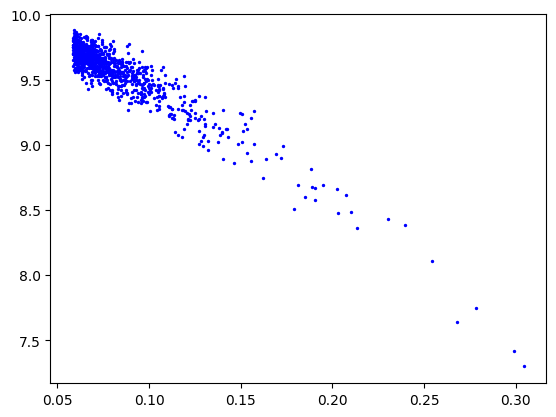

In [30]:
attr_index = 4
score = ensemble.scores[:, attr_index]
order = score.argsort()[::-1]
points = []
for it in range(0, 1000, 1):
    index = order[it]
    depths = []
    for estimator in ensemble.detectors[attr_index][1].estimators_:
        depths.append(np.sum(estimator.decision_path(mat[index: index + 1,:])))
    if it < 25:
        print('Rank: %d, Id: %d, Score: %.3f, Depth: %.2f' % (it, index, score[index], np.mean(depths)))
    points.append((score[index], np.mean(depths)))
points = np.array(points)
plt.scatter(points[:, 0], points[:, 1], s = 2, color='blue')
plt.show()

In [51]:
rules = []
class_count = {}
max_n_conds = 0
top_n = 100
filtered_id = set()
for attr_id in range(len(ensemble.detectors)):
    idxes = ensemble.scores[:, attr_id].argsort()[::-1][:top_n]
    for it, i in enumerate(idxes):
        conds, output = interpret_path(paths[i])
        class_count[output] = class_count.get(output, 0) + 1
        if i in filtered_id:
            continue
        filtered_id.add(i)
        rules.append({'cond': conds, 'predict': output, 'index': i, 'order': it, 'attr': attr_id })
        max_n_conds = max(len(conds), max_n_conds)
conds_per_line = 4
max_n_conds = math.ceil(max_n_conds / conds_per_line) * conds_per_line

In [54]:
print(len(rules))

141


In [33]:
f = open('anomaly_iforest.csv', 'w')

for it, rule in enumerate(rules):
    s = '' + str(rule['order'])
    line = 0
    n_conds = len(rule['cond'])
    n_lines = math.ceil(n_conds / conds_per_line)
    index = rule['index']

    for line in range(n_lines):
        if line == 0:
            s += ',#%d,IF,' % (index)
        else:
            s += ',,,'
        for pos in range(conds_per_line):
            i = pos + line * conds_per_line
            if i < n_conds:
                item = rule['cond'][i]
                s += item[0] + ',' + item[1] + ',' + str(item[2]) + ','
                s += 'AND,' if i < n_conds - 1 else '...,'
            else:
                s += '...,...,...,...,'
        if line == n_lines - 1:
            s = s[:-4]
            s += 'THEN,%s,%d,%3f' % (rule['predict'], np.sum(paths[index]['distribution']), paths[index]['confidence'])
        s += '\n'
    f.write(s + '\n')
f.close()

In [7]:
interpret_path(paths[7822])

([('housing', 'is', 'own'),
  ('property', 'is', 'real estate'),
  ('other_debtors', 'is', 'none')],
 'accept')

In [76]:
from unicodedata import numeric


marked = [7822, 5685, 2989, 3470, 5141, 5058, 9813, 1376, 3969, 7524, 7058, 3739, 3831, 453, 1107, 4529, 5776, 1338, 9709, 7921, 4958, 5032, 7417, 892, 6972, 3958, 2407, 932, 4101, 902, 3971, 146, 9544, 7381, 5875, 7165, 2853, 2107, 3855, 7712, 1061, 8968, 4245, 2805, 3347, 7748, 4970, 3786, 95, 3556, 5186, 8471, 8788, 6398, 6135, 4500, 9234, 3778, 3375, 8058, 9199, 2205, 1559, 7972, 2760, 250, 223, 9578, 303, 9804, 5608, 6384, 503, 4196, 4932, 7705, 6157, 2803, 5148, 8277, 190, 9431, 3477, 9156, 8893, 8457, 4930, 9061, 8279, 3453, 6226, 8381, 5124, 5786, 9902, 1208, 4456, 9906, 5527, 565, 9926, 2761, 2154, 582, 6133, 8975, 1564, 5967, 3906, 3694, 6819, 4557, 9653, 4017, 8027, 3487, 4172, 5947, 2529, 1934, 286, 9794, 2996, 2614, 7214, 1152, 5614, 5375, 5911, 2793, 9828, 4266, 2024, 3149, 8707, 3358]
mark_label = [1,0,1,0,1,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,1,0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0]
labeled_anomaly = [j for i, j in enumerate(marked) if mark_label[i] == 1]
labeled_non_anomaly = [j for i, j in enumerate(marked) if mark_label[i] == 0]
print(labeled_anomaly)

[7822, 2989, 5141, 5058, 1376, 3969, 3739, 4529, 892, 2407, 7712, 4245, 4970, 3556, 6398, 3778, 3375, 9199, 223, 9578, 9804, 7705, 6157, 2803, 5148, 9431, 8457, 9061, 9906, 565, 9926, 2761, 8975, 5967, 3906, 6819, 4017, 1934, 5375]


In [68]:
mat = np.array([p['sample'] for p in paths]).astype('float')
mat2 = mat.copy()
for i, path in enumerate(paths):
    mat2[i] *= (path['output'] + 1)

In [59]:
from sklearn.manifold import TSNE
x_tsne1 = TSNE(n_components=2).fit_transform(mat)

/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [69]:
from sklearn.manifold import TSNE
x_tsne2 = TSNE(n_components=2).fit_transform(mat2)

/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/lizhen/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [88]:
x_tsne = x_tsne1

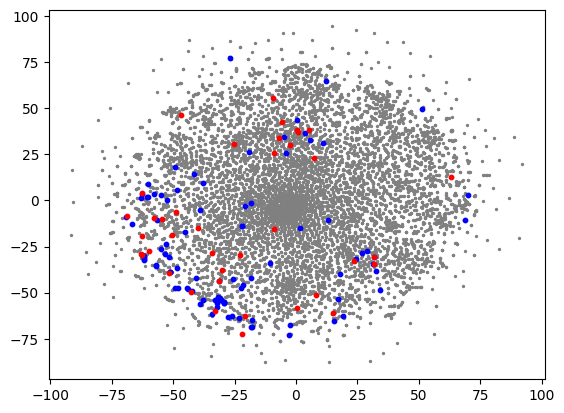

In [89]:
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[labeled_non_anomaly, 0], x_tsne[labeled_non_anomaly, 1], s = 10, color='blue')
plt.scatter(x_tsne[labeled_anomaly, 0], x_tsne[labeled_anomaly, 1], s = 10, color='red')
plt.show()